# Basic Probability Calculations

In [186]:
from scipy.stats import triang
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import rv_histogram

## Function
I choose a **triangular distribution**, which I can use to define a *localized distribution* and is defined by its lower limit, upper limit, and mode.

In [187]:
def triangular_distribution(lower, upper, mode, size):
    return triang.rvs(c=(mode-lower)/(upper-lower), loc=lower, scale=upper-lower, size=size)

## Prior Box

In [188]:
def define_prior_box(lower_x, upper_x, mode_x, lower_y, upper_y, mode_y, size):
    x_samples = triangular_distribution(lower_x, upper_x, mode_x, size)
    y_samples = triangular_distribution(lower_y, upper_y, mode_y, size)
    prior_box = list(zip(x_samples, y_samples))
    return prior_box

lower_x=0
upper_x=10
mode_x=5
lower_y=0
upper_y=10
mode_y=5
size_pb=1000
prior_box = define_prior_box(lower_x,upper_x,mode_x,lower_y,upper_y,mode_y,size_pb)

## Sampling
To sample the pdf on a 2D regular grid within the prior box:
- I first create a *meshgrid* of points covering the range of the prior box,
- then I evaluate the function at each point on the grid.

In [189]:
def sampling(lower, upper, mode, prior_box, grid_res): #grid_res is the number of points along each axis in the grid
    #extraction of x and y from the prior box
    x, y = zip(*prior_box)
    
    #creation of a meshgrid of points within the prior box
    x_grid = np.linspace(min(x), max(x), grid_res)
    y_grid = np.linspace(min(y), max(y), grid_res)
    xx, yy = np.meshgrid(x_grid, y_grid) #these contain the x and y coordinates of the grid points
    
    #evaluation of the function at each point on the grid
    samples = triang.pdf(xx, c=(mode-lower)/(upper-lower), loc=lower, scale=upper-lower) * triang.pdf(yy, c=(mode-lower)/(upper-lower), loc=lower, scale=upper-lower)

    '''
    samples=np.empty_like(xx)

    for i in range(grid_res):
        for j in range(grid_res):
            samples[i,j]=triangular_distribution(lower,upper,mode,size=1)[0] #sampling at each grid point
    '''
    
    return xx, yy, samples.reshape(grid_res,grid_res)

## Normalization
The PDF of the triangular distribution can be calculated using the formula:

$
f(x) = \begin{cases} 
0 & \text{for } x < a \\
\frac{2(x-a)}{(b-a)(c-a)} & \text{for } a \leq x < c \\
\frac{2(b-x)}{(b-a)(b-c)} & \text{for } c \leq x < b \\
0 & \text{for } x \geq b
\end{cases}
$

where $a$ is the lower limit, $b$ is the upper limit, and $c$ is the mode.

* So first I have to define a function that calculates the PDF of the triangular distribution at a given point $x$.

In [190]:
def triangular_pdf(x, lower, upper, mode):
    if x < lower or x > upper:
        return 0
    elif lower <= x < mode:
        return 2 * (x - lower) / ((upper - lower) * (mode - lower))
    elif mode <= x < upper:
        return 2 * (upper - x) / ((upper - lower) * (upper - mode))

* Then I define a function (*normalize_triangular_pdf*) that:
    - integrates the PDF function over the range $[lower, upper]$ using *scipy.integrate.quad* to find the total area under the curve,
    - calculates the scaling factor to normalize the distribution such that the area under the curve equals 1.

In [191]:
def normalize_triangular_pdf(lower, upper, mode):
    integral = integrate.quad(lambda x: triangular_pdf(x, lower, upper, mode), lower, upper)[0]
    scaling_factor = 1 / integral
    return scaling_factor

lower=0
upper=10
mode=5
scaling_factor=normalize_triangular_pdf(lower,upper,mode)
print(scaling_factor) #1.0 -> the function was already normalized

1.0


## Contour Plot

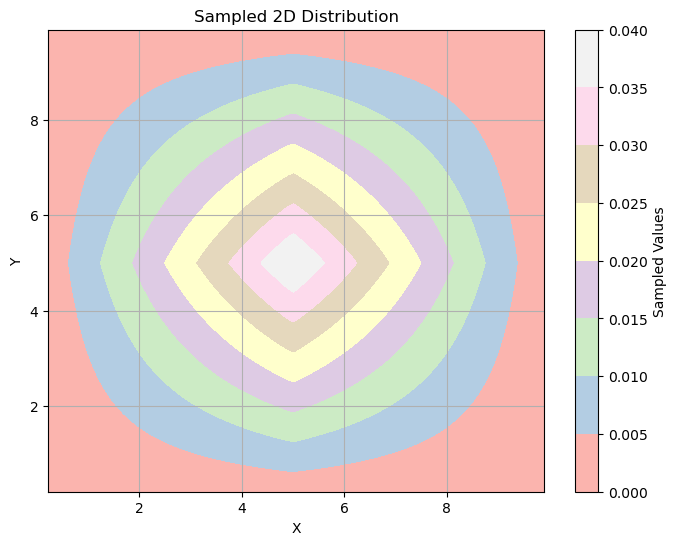

In [192]:
grid_res=100
x_grid,y_grid,samples_tr_dist=sampling(lower,upper,mode,prior_box,grid_res)

#contour plot of the sampled distribution
plt.figure(figsize=(8, 6))
plt.contourf(x_grid, y_grid, samples_tr_dist, cmap='Pastel1')
plt.colorbar(label='Sampled Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Sampled 2D Distribution')
plt.grid(True)
plt.show()

## 3D Plot

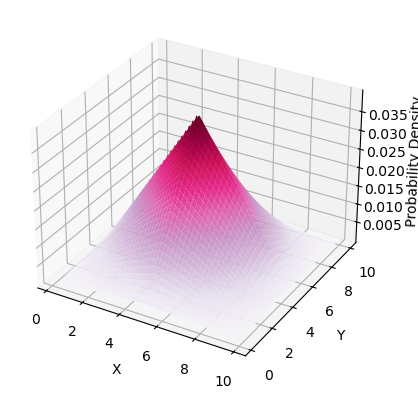

In [193]:
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(x_grid,y_grid,samples_tr_dist,cmap='PuRd')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Probability Density')
plt.show()

## Marginalization
Now I marginalize the joint distribution, represented by the array *samples_tr_dist*, over the rows of this array to obtain the marginal distribution of $x$, and over the columns to obtain the marginal distribution of $y$.

In [194]:
marginal_x=np.sum(samples_tr_dist,axis=1)
marginal_y=np.sum(samples_tr_dist,axis=0)

Plot of the two 1D distributions

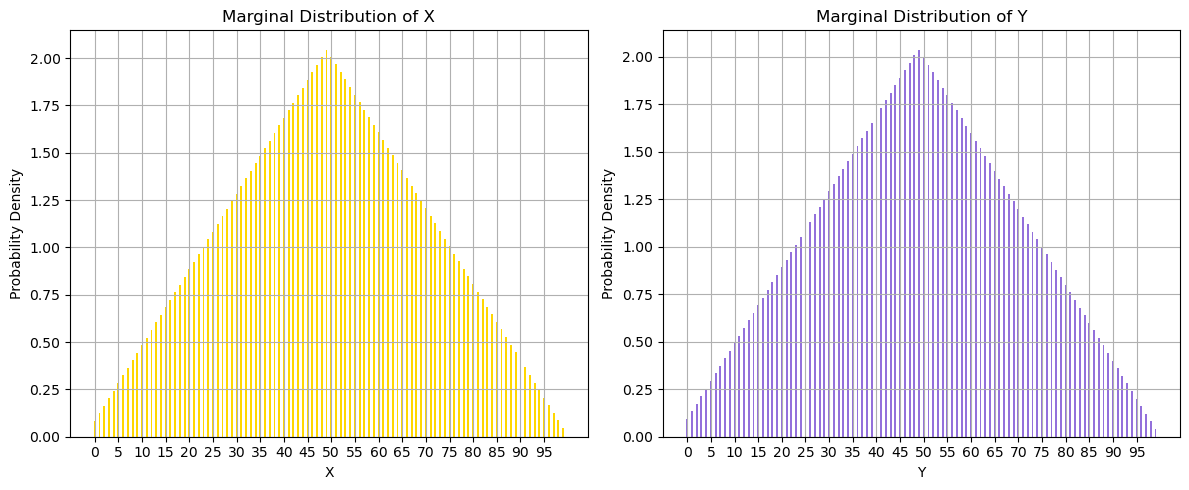

In [195]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#marginal distribution of x
axs[0].bar(range(len(marginal_x)), marginal_x, width=0.4, color='gold')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Probability Density')
axs[0].set_title('Marginal Distribution of X')
axs[0].set_xticks(range(0, len(marginal_x), 5))
axs[0].grid(True)

#marginal distribution of y
axs[1].bar(range(len(marginal_y)), marginal_y, width=0.4, color='mediumpurple')
axs[1].set_xlabel('Y')
axs[1].set_ylabel('Probability Density')
axs[1].set_title('Marginal Distribution of Y')
axs[1].set_xticks(range(0, len(marginal_y), 5))
axs[1].grid(True)

plt.tight_layout()
plt.show()


Both plots show bars which are higer around the mode of the triangular distribution ($mode_x=5, mode_y=5$), indicating higher probability density around this value.

### Check that the 1D distributions are normalized

* First, I define the marginal distribution functions:

In [196]:
def marginal_x_function(x):
    return np.interp(x, range(len(marginal_x)), marginal_x)

def marginal_y_function(y):
    return np.interp(y, range(len(marginal_y)), marginal_y)

* Then, I normalize them:

In [197]:
N_x, _ = integrate.quad(marginal_x_function, np.min(x_grid), np.max(x_grid))
N_y, _ = integrate.quad(marginal_y_function, np.min(y_grid), np.max(y_grid))

#print("Scaling factor for marginal x:", 1 / N_x)
#print("Scaling factor for marginal y:", 1 / N_y)

* Finally, I define the *normalized* marginal distribution functions and I verify that they are normalized:

In [198]:
def marginal_x_function_normalized(x):
    return np.interp(x, range(len(marginal_x)), marginal_x)/N_x

def marginal_y_function_normalized(y):
    return np.interp(y, range(len(marginal_y)), marginal_y)/N_y

Norm_x,_=integrate.quad(marginal_x_function_normalized, np.min(x_grid), np.max(x_grid))
Norm_y,_=integrate.quad(marginal_y_function_normalized, np.min(y_grid), np.max(y_grid))

#print("Norm of marginal x:",Norm_x)
#print("Norm of marginal x:",Norm_y)

## Cumulative Distribution Function of the 1D Distribution

In [199]:
marginal_x_normalized_array=marginal_x_function_normalized(x_grid)
hist,bins=np.histogram(marginal_x_normalized_array,bins='auto',density=True)
hist_rv=rv_histogram((hist,bins))
cdf=hist_rv.cdf(x_grid)